# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [2]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

# Visualize Data

In [3]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'Russian_Blue_216.jpg'

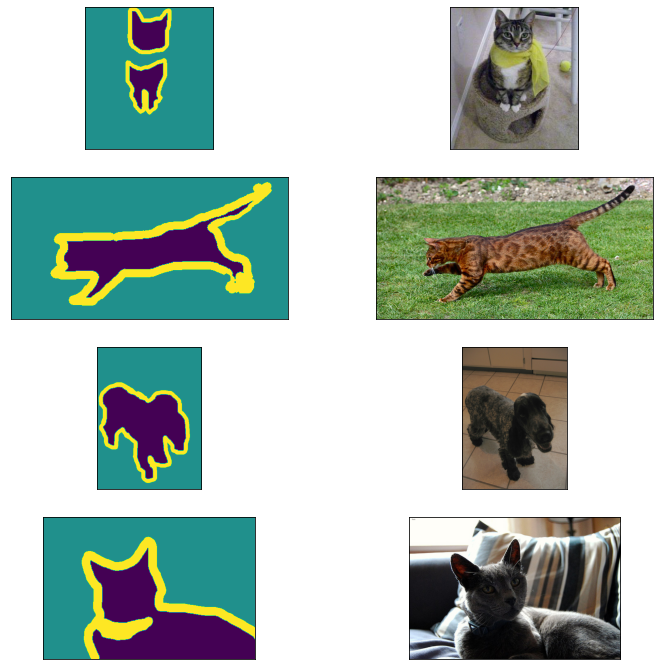

In [6]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [13]:
img = Image.open(os.path.join(trimaps_dir, maps[-1]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [21]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdata-margaux'
# points to a docker image that is implemented for semantic segmentation
training_image = get_image_uri(boto3.Session().region_name, 'semantic-segmentation',
                               repo_version='latest')
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:1


In [14]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [15]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:03<00:00, 2108.44it/s]


In [16]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [17]:
print(len(train_annots), len(train_images))

5549 5549


# Uploading Data to S3

In [22]:
bucket_name

'petsdata-margaux'

In [23]:
sess = sagemaker.Session()
print('Starting upload')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name, 
                                            key_prefix='train_annotation')
print('Training annotation images uploaded')

print('Starting upload')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name, 
                                            key_prefix='validation_annotation')
print('Validation annotation images uploaded')

Starting upload
Training images uploaded
Training annotation images uploaded
Starting upload
Validation images uploaded
Validation annotation images uploaded


In [24]:
s3_validation_annotation_path

's3://petsdata-margaux/validation_annotation'

# SageMaker Estimator

In [25]:
training_image

'811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:1'

In [58]:
model_segmentation = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
#     use_spot_instances=True,
    volume_size=100, 
    max_run=36000, #seconds
    input_mode='File',
    ouput_path='s3://petsdata-margaux/output',
    sagemaker_session=sess
)

# Hyperparameters

In [59]:
model_segmentation.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True, # ImageNet
    crop_size=240,
    num_classes=4, # because we have classes 1,2,3 instead of 0,1,2
    epochs=10,
    learning_rate=0.0001,
    optimizer='rmsprop',
    lr_scheduler='poly',
    mini_batch_size=16,
    validation_mini_batch_size=16,
    num_training_samples=len(train_images),
    early_stopping=True,
    early_stopping_patience=5,
    early_stopping_min_epochs=10
)


# Data Channels

In [60]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                                       content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                                       content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                                       content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                                       content_type='image/png', s3_data_type='S3Prefix')

In [61]:
data_channel = {
    'train': train_data,
    'validation': validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation': validation_annotation_data
}

In [62]:
data_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7f681ad7efd0>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f681ad7e4a8>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7f681ad7e668>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7f681ad7e470>}

# Model Training

In [63]:
model_segmentation.fit(inputs=data_channel, logs=True)

2021-09-27 23:41:01 Starting - Starting the training job...
2021-09-27 23:41:06 Starting - Launching requested ML instancesProfilerReport-1632786061: InProgress
......
2021-09-27 23:42:16 Starting - Preparing the instances for training.........
2021-09-27 23:43:59 Downloading - Downloading input data..................
2021-09-27 23:47:01 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[09/27/2021 23:47:02 INFO 140352821331776] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'backbone': 'resnet-50', 'algorithm': 'fcn', 'use_pretrained_model': 'True', 'crop_size': '240', 'epochs': '10', 'learning_rate': '0.001', 'optimizer': 'sgd', 'lr_scheduler': 'poly', 'lr_scheduler_factor': '0.1', 'weight_decay': '0.0001', 'momentum': '0.9', 'gamma1': '0.9', 'gamma2': '0.9', 'mini

# Deploy Model

In [64]:
deployed_model = model_segmentation.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

---------------!\Model deployed!


In [65]:
deployed_model

# Predictions

In [66]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1841


In [71]:
# # older sagemaker 
# deployed_model.content_type = 'image/jpeg'
# deployed_model.accept = 'image/png'

In [77]:
index = 0

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

# image = np.array(Image.open(image_path))
results = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept': 'image/png'})

In [78]:
mask = np.array(Image.open(io.BytesIO(results)))

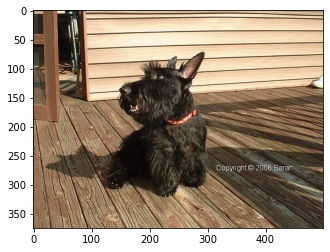

In [79]:
plt.imshow(plt.imread(image_path));

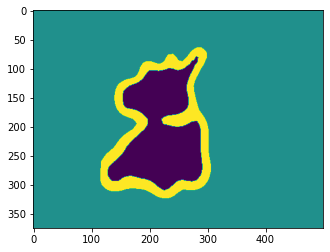

In [80]:
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [83]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint_name)